# 04 — Apply ML Models (Clean Version)

**Project:** *Economic Stress and Digital Behavior: How Economic Changes Shape Social Media Usage in Europe*

This notebook focuses on the **Apply ML methods** requirement:

1. **Regression (level prediction):** Predict a country’s social-media participation using macroeconomic indicators, with a **time-aware split**.
2. **Classification (direction of change):** Predict whether participation **increases vs not** and visualize a **confusion matrix**.
3. **H2 (Moderation) via linear model betas:** Test whether **consumer confidence moderates** the effect of economic stress using an **interaction term** (`stress × confidence`), and visualize:
   - **Model improvement** (RMSE/R²) when adding confidence + interaction
   - **Marginal effect** of stress as a function of confidence (beta-based)

All figures are saved under: `figures/`.


In [1]:
# ===== 0) Imports & Helpers =====
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVR

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

np.random.seed(42)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def pick_col(cols, patterns):
    """Pick the first column name matching any regex in patterns."""
    for p in patterns:
        r = re.compile(p, flags=re.I)
        hits = [c for c in cols if r.search(c)]
        if hits:
            return hits[0]
    return None

os.makedirs("figures", exist_ok=True)


## 1) Load annual panel data

**Input file:** `panel_annual_final.csv`  
Expected structure: country × year panel with participation + macro variables.


In [2]:
# ===== 1) Load annual panel =====
df = pd.read_csv("data/processed/panel_annual_final.csv")
print("Annual shape:", df.shape)
print("Annual columns (first 40):", df.columns[:40].tolist())
df.head()


Annual shape: (424, 15)
Annual columns (first 40): ['geo', 'year', 'sm_participation', 'inflation', 'unemployment', 'cci', 'Facebook', 'Instagram', 'YouTube', 'LinkedIn', 'ent_share', 'prof_share', 'ent_minus_prof', 'd_sm', 'stress']


,geo,year,sm_participation,inflation,unemployment,cci,Facebook,Instagram,YouTube,LinkedIn,ent_share,prof_share,ent_minus_prof,d_sm,stress
0,AL,2018,48.33,1.819741,NaN,NaN,79.240833,3.094167,7.065000,0.298333,89.400000,0.298333,89.101667,NaN,NaN
1,AL,2019,52.13,1.450360,NaN,NaN,69.003333,5.556667,4.623333,0.275833,79.183333,0.275833,78.907500,3.80,NaN
2,AL,2020,54.80,1.512636,NaN,NaN,75.620000,6.143333,3.115000,0.157500,84.878333,0.157500,84.720833,2.67,NaN
3,AL,2021,60.77,3.825186,NaN,NaN,91.660833,1.360000,1.035833,0.115833,94.056667,0.115833,93.940833,5.97,NaN
4,AL,2022,64.07,7.543537,NaN,NaN,93.218333,1.830000,1.087500,0.140000,96.135833,0.140000,95.995833,3.30,NaN


## 2) Detect key columns + standardize names

We standardize to:
- `geo` (country)
- `year`
- `sm_participation` (target)

Then detect macro columns (if present):
- inflation (HICP)
- unemployment
- consumer confidence (CCI)
- GDP growth


In [3]:
# ===== 2) Detect and standardize =====
cols = df.columns.tolist()

country_col = pick_col(cols, [r"^geo$", r"country", r"^cntry$", r"location"])
year_col    = pick_col(cols, [r"^year$", r"time", r"survey[_ ]?year"])
target_col  = pick_col(cols, [r"sm[_ ]?participation", r"social.*participation", r"tin00127"])

print("Detected:", {"country": country_col, "year": year_col, "target": target_col})

if not (country_col and year_col and target_col):
    raise ValueError("Could not detect key columns. Set country_col/year_col/target_col manually.")

df = df.rename(columns={country_col:"geo", year_col:"year", target_col:"sm_participation"}).copy()
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df["sm_participation"] = pd.to_numeric(df["sm_participation"], errors="coerce")

df = df.dropna(subset=["geo","year","sm_participation"]).sort_values(["geo","year"]).reset_index(drop=True)

# detect macro columns
cols = df.columns.tolist()
infl_col  = pick_col(cols, [r"infl", r"hicp"])
unemp_col = pick_col(cols, [r"unemp", r"^une", r"jobless"])
cci_col   = pick_col(cols, [r"cci", r"consumer[_ ]?confidence", r"confidence"])
gdp_col   = pick_col(cols, [r"gdp.*growth", r"gdp_growth", r"ny\.gdp"])

print("Macro detected:", {"inflation": infl_col, "unemployment": unemp_col, "cci": cci_col, "gdp_growth": gdp_col})

macro_base = [c for c in [infl_col, unemp_col, gdp_col] if c is not None]
macro_plus_cci = macro_base + ([cci_col] if cci_col is not None else [])

if len(macro_base) == 0:
    raise ValueError("No macro features detected. Please set macro_base manually.")

df.head()


Detected: {'country': 'geo', 'year': 'year', 'target': 'sm_participation'}
Macro detected: {'inflation': 'inflation', 'unemployment': 'unemployment', 'cci': 'cci', 'gdp_growth': None}


,geo,year,sm_participation,inflation,unemployment,cci,Facebook,Instagram,YouTube,LinkedIn,ent_share,prof_share,ent_minus_prof,d_sm,stress
0,AL,2018,48.33,1.819741,NaN,NaN,79.240833,3.094167,7.065000,0.298333,89.400000,0.298333,89.101667,NaN,NaN
1,AL,2019,52.13,1.450360,NaN,NaN,69.003333,5.556667,4.623333,0.275833,79.183333,0.275833,78.907500,3.80,NaN
2,AL,2020,54.80,1.512636,NaN,NaN,75.620000,6.143333,3.115000,0.157500,84.878333,0.157500,84.720833,2.67,NaN
3,AL,2021,60.77,3.825186,NaN,NaN,91.660833,1.360000,1.035833,0.115833,94.056667,0.115833,93.940833,5.97,NaN
4,AL,2022,64.07,7.543537,NaN,NaN,93.218333,1.830000,1.087500,0.140000,96.135833,0.140000,95.995833,3.30,NaN


## 3) Create change targets (Δ participation) and classification label

- `delta_sm = sm_participation - lag(sm_participation)` within each country  
- `increase_flag = 1(delta_sm > 0)` for classification


In [4]:
# ===== 3) Change targets =====
df["sm_lag1"] = df.groupby("geo")["sm_participation"].shift(1)
df["delta_sm"] = df["sm_participation"] - df["sm_lag1"]
df["increase_flag"] = (df["delta_sm"] > 0).astype("Int64")

df_change = df.dropna(subset=["delta_sm"]).copy()
df_change[["geo","year","sm_participation","delta_sm","increase_flag"]].head()


,geo,year,sm_participation,delta_sm,increase_flag
1,AL,2019,52.13,3.80,1
2,AL,2020,54.80,2.67,1
3,AL,2021,60.77,5.97,1
4,AL,2022,64.07,3.30,1
5,AL,2023,66.27,2.20,1


## 4) Time-aware train/test split (avoid leakage)

Train on earlier years; test on the **last 2 years**.


In [5]:
# ===== 4) Time split =====
years = sorted(df["year"].dropna().unique().tolist())
if len(years) < 3:
    raise ValueError("Not enough years to do time-based split.")
test_years = years[-2:]
train_df = df[df["year"].isin(years[:-2])].copy()
test_df  = df[df["year"].isin(test_years)].copy()

print("Test years:", test_years)
print("Train size:", train_df.shape, "Test size:", test_df.shape)


Test years: [2023, 2024]
Train size: (353, 18) Test size: (70, 18)


## 5) Preprocessing + model zoo

Preprocessing:
- Numeric: median imputation + scaling
- Categorical (`geo`): one-hot encoding

Models tested:
- LinearRegression / Ridge / Lasso / ElasticNet
- RandomForest / GradientBoosting
- SVR


In [6]:
# ===== 5) Preprocess + models =====
def make_preprocess(num_cols, cat_cols):
    num_tf = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ])
    cat_tf = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])
    return ColumnTransformer([
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols)
    ])

cat_cols = ["geo"]

reg_models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "Lasso(alpha=0.01)": Lasso(alpha=0.01),
    "ElasticNet(a=0.01,l1=0.5)": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR(RBF)": SVR(C=10.0, gamma="scale")
}


## 6) Regression: predict participation level (Apply ML)

We compare two feature sets:
- **Base:** macro variables + `year` + country (one-hot)
- **Base + CCI:** macro variables + `cci` + `year` + country (one-hot)

`year` is included as a feature to help capture time trends.


In [7]:
# ===== 6) Regression benchmark =====
def run_regression(feature_cols, label):
    feature_cols = list(dict.fromkeys(feature_cols + ["year"]))  # add year
    X_train = train_df[feature_cols + cat_cols].copy()
    y_train = train_df["sm_participation"].astype(float).values
    X_test  = test_df[feature_cols + cat_cols].copy()
    y_test  = test_df["sm_participation"].astype(float).values

    prep = make_preprocess(num_cols=feature_cols, cat_cols=cat_cols)

    rows, trained = [], {}
    for name, mdl in reg_models.items():
        pipe = Pipeline([("prep", prep), ("model", mdl)])
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
        rows.append({
            "feature_set": label,
            "model": name,
            "rmse": rmse(y_test, pred),
            "mae": float(mean_absolute_error(y_test, pred)),
            "r2": float(r2_score(y_test, pred))
        })
        trained[name] = pipe

    out = pd.DataFrame(rows).sort_values("rmse").reset_index(drop=True)
    best_name = out.iloc[0]["model"]
    return out, best_name, trained[best_name], X_test, y_test

res_base, best_base, pipe_base, Xte_base, yte_base = run_regression(macro_base, "base")
res_base


,feature_set,model,rmse,mae,r2
0,base,"ElasticNet(a=0.01,l1=0.5)",5.597218,4.249172,0.664421
1,base,Ridge(alpha=1.0),5.638098,4.265513,0.659501
2,base,SVR(RBF),5.657612,4.298642,0.657140
3,base,Lasso(alpha=0.01),5.780881,4.354154,0.642037
4,base,LinearRegression,5.902467,4.464223,0.626821
5,base,RandomForest,6.366527,5.432414,0.565834
6,base,GradientBoosting,6.668569,5.696225,0.523661


In [8]:
# ===== 6.1) Add CCI if available =====
if cci_col is None:
    print("No CCI detected -> skipping base+cci comparison.")
    res_plus = None
else:
    res_plus, best_plus, pipe_plus, Xte_plus, yte_plus = run_regression(macro_plus_cci, "base+cci")
    res_plus


## 7) Pick final best model and create “fit” visuals

Visuals:
- Prediction vs Actual (many points) + 45° line + fit line
- Residual histogram
- Yearly average: Actual vs Predicted (test years)

All figures are saved under `figures/`.


,feature_set,best_model,rmse,r2
0,base+cci,"ElasticNet(a=0.01,l1=0.5)",5.520042,0.673611
1,base,"ElasticNet(a=0.01,l1=0.5)",5.597218,0.664421


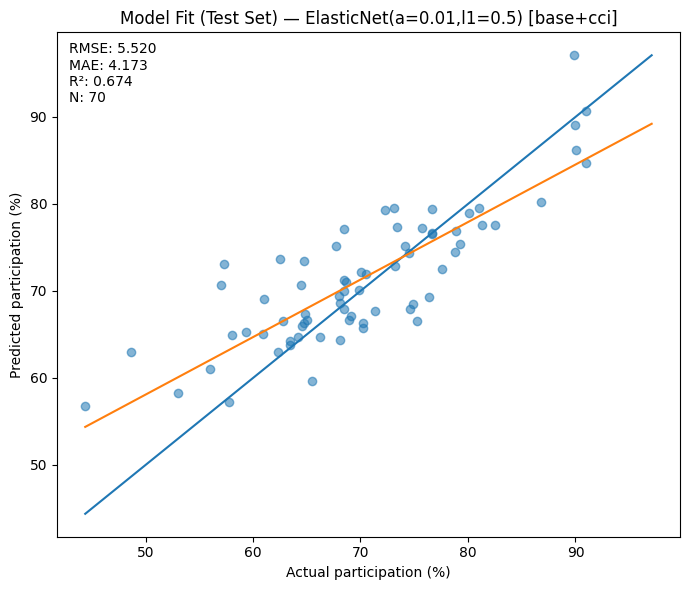

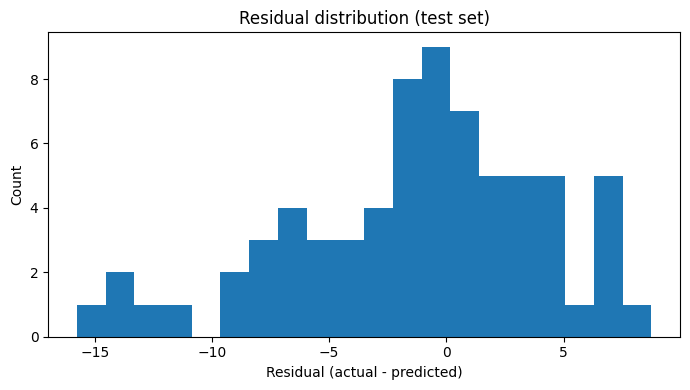

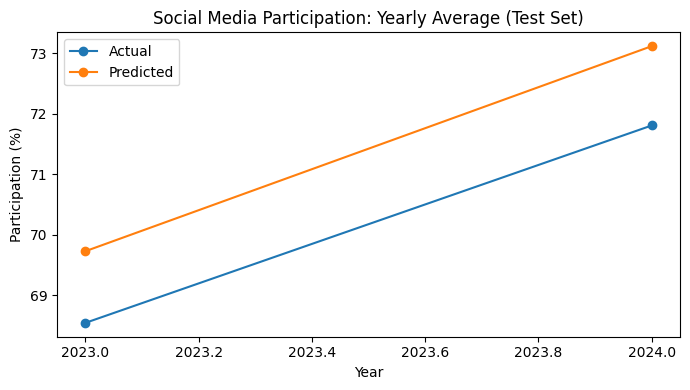

Final best model: ElasticNet(a=0.01,l1=0.5) | Feature set: base+cci


In [9]:
# ===== 7) Choose best feature set + diagnostics =====
summary = [{
    "feature_set": "base",
    "best_model": best_base,
    "rmse": float(res_base.iloc[0]["rmse"]),
    "r2": float(res_base.iloc[0]["r2"])
}]
if cci_col is not None:
    summary.append({
        "feature_set": "base+cci",
        "best_model": best_plus,
        "rmse": float(res_plus.iloc[0]["rmse"]),
        "r2": float(res_plus.iloc[0]["r2"])
    })
summary = pd.DataFrame(summary).sort_values("rmse").reset_index(drop=True)
display(summary)

final_set = summary.iloc[0]["feature_set"]
if final_set == "base":
    best_pipe, best_name, X_test, y_test = pipe_base, best_base, Xte_base, yte_base
else:
    best_pipe, best_name, X_test, y_test = pipe_plus, best_plus, Xte_plus, yte_plus

y_pred = best_pipe.predict(X_test)

# --- Scatter: prediction vs actual ---
rmse_val = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae_val = float(mean_absolute_error(y_test, y_pred))
r2_val = float(r2_score(y_test, y_pred))

plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.55)

lo = min(np.min(y_test), np.min(y_pred))
hi = max(np.max(y_test), np.max(y_pred))
plt.plot([lo, hi], [lo, hi])

# Fit line (visual guidance)
b1, b0 = np.polyfit(y_test, y_pred, 1)
xx = np.linspace(lo, hi, 100)
plt.plot(xx, b1*xx + b0)

plt.xlabel("Actual participation (%)")
plt.ylabel("Predicted participation (%)")
plt.title(f"Model Fit (Test Set) — {best_name} [{final_set}]")
plt.text(0.02, 0.98,
         f"RMSE: {rmse_val:.3f}\nMAE: {mae_val:.3f}\nR²: {r2_val:.3f}\nN: {len(y_test)}",
         transform=plt.gca().transAxes, va="top")
plt.tight_layout()
plt.savefig("figures/pred_vs_actual_scatter.png", dpi=200, bbox_inches="tight")
plt.show()

# --- Residuals ---
resid = y_test - y_pred
plt.figure(figsize=(7,4))
plt.hist(resid, bins=20)
plt.xlabel("Residual (actual - predicted)")
plt.ylabel("Count")
plt.title("Residual distribution (test set)")
plt.tight_layout()
plt.savefig("figures/residual_hist.png", dpi=200, bbox_inches="tight")
plt.show()

# --- Yearly averages in test ---
tmp = test_df[["year"]].copy()
tmp["actual"] = y_test
tmp["pred"] = y_pred
avg = tmp.groupby("year")[["actual","pred"]].mean().reset_index()

plt.figure(figsize=(7,4))
plt.plot(avg["year"], avg["actual"], marker="o", label="Actual")
plt.plot(avg["year"], avg["pred"], marker="o", label="Predicted")
plt.title("Social Media Participation: Yearly Average (Test Set)")
plt.xlabel("Year")
plt.ylabel("Participation (%)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/yearly_avg_test.png", dpi=200, bbox_inches="tight")
plt.show()

print("Final best model:", best_name, "| Feature set:", final_set)


## 8) Feature importance (Permutation Importance)

Permutation importance is computed w.r.t. the **original input features** (before transformations),
which makes the results easy to interpret (e.g., inflation vs unemployment vs year).


In [10]:
# ===== 8) Permutation importance =====
mask = (~X_test.isna().any(axis=1)) & (~pd.isna(y_test))
X_clean = X_test.loc[mask]
y_clean = y_test[mask]

perm = permutation_importance(best_pipe, X_clean, y_clean, n_repeats=10, random_state=42, n_jobs=1)
perm_df = pd.DataFrame({
    "feature": X_clean.columns.tolist(),
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True)

perm_df.head(10)


,feature,importance_mean,importance_std
0,geo,1.216811,0.268718
1,unemployment,0.048914,0.014566
2,inflation,0.029383,0.006450
3,year,0.028163,0.013688
4,cci,-0.005606,0.003681


## 9) Classification: predict “Increase vs No increase” (Confusion Matrix)

Target:
- `increase_flag = 1(delta_sm > 0)`

This reframes the problem as a **directional** forecast: will participation rise?


,model,accuracy,f1
0,LogisticRegression,0.771429,0.868852
1,RandomForest,0.742857,0.847458
2,GradientBoosting,0.742857,0.842105


<Figure size 600x500 with 0 Axes>

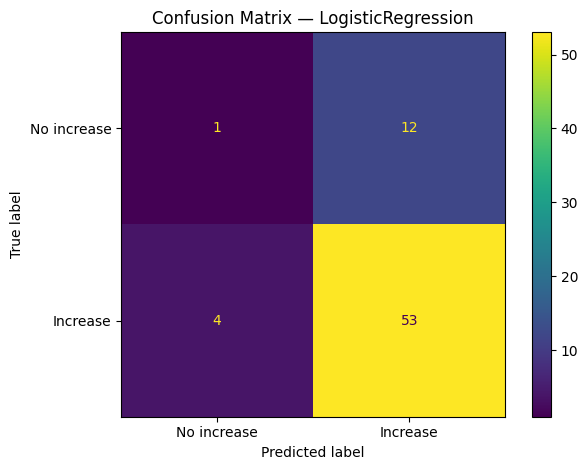

In [11]:
# ===== 9) Classification + confusion matrix =====
years_c = sorted(df_change["year"].unique().tolist())
test_years_c = years_c[-2:] if len(years_c) >= 4 else years_c[-1:]
train_c = df_change[df_change["year"].isin(years_c[:-len(test_years_c)])].copy()
test_c  = df_change[df_change["year"].isin(test_years_c)].copy()

feat_cols = macro_plus_cci if (cci_col is not None) else macro_base
feat_cols = list(dict.fromkeys(feat_cols + ["year"]))  # add year
feat_cols = [c for c in feat_cols if c in df_change.columns]

Xtr = train_c[feat_cols + ["geo"]].copy()
ytr = train_c["increase_flag"].astype(int).values
Xte = test_c[feat_cols + ["geo"]].copy()
yte = test_c["increase_flag"].astype(int).values

prep_c = make_preprocess(num_cols=feat_cols, cat_cols=["geo"])

clf_models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

rows = []
best_clf_name, best_f1 = None, -1.0
best_clf_pipe = None

for name, clf in clf_models.items():
    pipe = Pipeline([("prep", prep_c), ("model", clf)])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    acc = float(accuracy_score(yte, pred))
    f1  = float(f1_score(yte, pred))
    rows.append({"model": name, "accuracy": acc, "f1": f1})
    if f1 > best_f1:
        best_f1 = f1
        best_clf_name = name
        best_clf_pipe = pipe

clf_results = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)
display(clf_results)

pred_best = best_clf_pipe.predict(Xte)

plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(
    yte, pred_best,
    display_labels=["No increase", "Increase"],
    values_format="d"
)
plt.title(f"Confusion Matrix — {best_clf_name}")
plt.tight_layout()
plt.savefig("figures/confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()


## 10) H2 (Moderation) — Linear regression with interaction (beta interpretation)

Instead of splitting into “low/high confidence”, we estimate a **linear interaction model**:

\[
\text{participation} = \beta_0 + \beta_1 \cdot \text{stress} + \beta_2 \cdot \text{confidence} + \beta_3 \cdot (\text{stress} \times \text{confidence}) + \dots
\]

**Interpretation:**
- \(\beta_1\) is the stress effect when confidence is at its mean (after scaling)
- \(\beta_3\) tells how the stress effect changes as confidence changes  
  (marginal effect of stress = \(\beta_1 + \beta_3 \cdot \text{confidence}\))

We also compare predictive fit (RMSE/R²) with vs without the interaction.


,model,rmse,r2
0,Linear (no interaction),5.993154,0.582537
1,Linear (stress×confidence),6.079351,0.570443


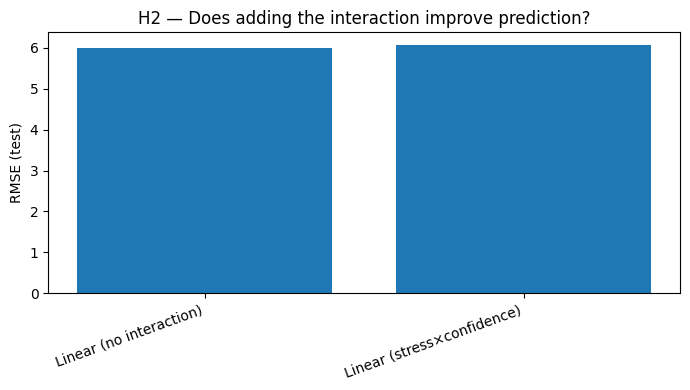

,feature,beta
0,num__stress_raw,23.605180
1,num__conf_raw,0.475163
2,num__stress_x_conf,-23.795734


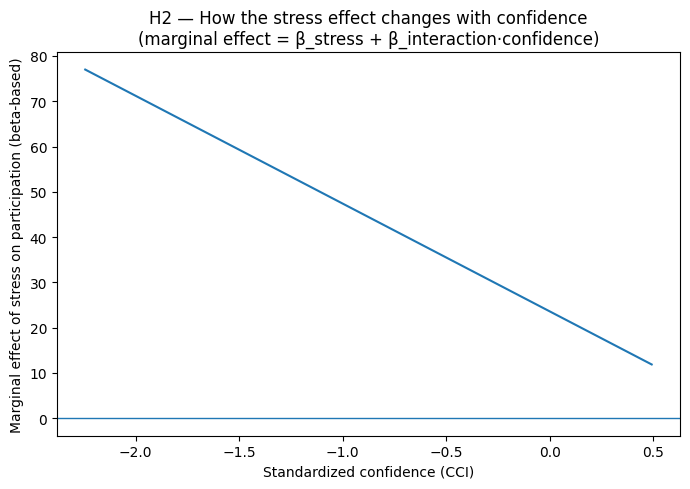

In [19]:
# ===== 10) H2: Interaction model (beta-based) =====
if cci_col is None:
    print("No CCI column -> cannot run H2 interaction model.")
elif infl_col is None or unemp_col is None:
    print("Need inflation and unemployment to build stress proxy.")
else:
    dd = df.copy()

    # Stress proxy: z(inflation) + z(unemployment)
    dd["stress_raw"] = (dd[infl_col] - dd[infl_col].mean())/dd[infl_col].std() +                        (dd[unemp_col] - dd[unemp_col].mean())/dd[unemp_col].std()

    # confidence raw
    dd["conf_raw"] = pd.to_numeric(dd[cci_col], errors="coerce")

    # interaction (raw scale; we will standardize in preprocessing)
    dd["stress_x_conf"] = dd["stress_raw"] * dd["conf_raw"]

    # features for H2 linear model
    h2_num = ["stress_raw", "conf_raw", "stress_x_conf", "year"]
    h2_cat = ["geo"]

    # split consistent with earlier
    train_h2 = dd[dd["year"].isin(years[:-2])].dropna(subset=h2_num + h2_cat + ["sm_participation"]).copy()
    test_h2  = dd[dd["year"].isin(test_years)].dropna(subset=h2_num + h2_cat + ["sm_participation"]).copy()

    # Model A: without interaction (stress + conf + year + geo)
    h2_num_A = ["stress_raw", "conf_raw", "year"]
    prep_A = make_preprocess(num_cols=h2_num_A, cat_cols=h2_cat)
    pipe_A = Pipeline([("prep", prep_A), ("model", LinearRegression())])

    XtrA = train_h2[h2_num_A + h2_cat]
    ytr  = train_h2["sm_participation"].astype(float).values
    XteA = test_h2[h2_num_A + h2_cat]
    yte  = test_h2["sm_participation"].astype(float).values

    pipe_A.fit(XtrA, ytr)
    predA = pipe_A.predict(XteA)

    # Model B: with interaction
    prep_B = make_preprocess(num_cols=h2_num, cat_cols=h2_cat)
    pipe_B = Pipeline([("prep", prep_B), ("model", LinearRegression())])

    XtrB = train_h2[h2_num + h2_cat]
    XteB = test_h2[h2_num + h2_cat]

    pipe_B.fit(XtrB, ytr)
    predB = pipe_B.predict(XteB)

    # Compare fit
    comp = pd.DataFrame([
        {"model": "Linear (no interaction)", "rmse": rmse(yte, predA), "r2": float(r2_score(yte, predA))},
        {"model": "Linear (stress×confidence)", "rmse": rmse(yte, predB), "r2": float(r2_score(yte, predB))}
    ])
    display(comp)

    # Bar plot of RMSE
    plt.figure(figsize=(7,4))
    plt.bar(comp["model"], comp["rmse"])
    plt.ylabel("RMSE (test)")
    plt.title("H2 — Does adding the interaction improve prediction?")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig("figures/h2_rmse_comparison.png", dpi=200, bbox_inches="tight")
    plt.show()

    # ----- Extract betas for stress, conf, interaction (scaled features) -----
    prep = pipe_B.named_steps["prep"]
    feat_names = prep.get_feature_names_out()
    coefs = pipe_B.named_steps["model"].coef_

    coef_map = pd.DataFrame({"feature": feat_names, "beta": coefs})
    # keep the main H2 terms
    keep = coef_map[coef_map["feature"].str.contains("stress_raw|conf_raw|stress_x_conf", case=False, regex=True)].copy()
    display(keep)

    # ----- Marginal effect of stress as function of confidence (robust) -----

def get_beta(name_part):
    row = coef_map[coef_map["feature"].str.contains(name_part, case=False, regex=False)]
    return float(row["beta"].iloc[0]) if len(row) else np.nan

beta_stress = get_beta("stress_raw")
beta_inter  = get_beta("stress_x_conf")

# Transform test design matrix (may be sparse)
XteB_trans = prep.transform(XteB)

# find conf column index in transformed feature names
conf_idx = [i for i, n in enumerate(feat_names) if "conf_raw" in n.lower()]

if len(conf_idx) == 0:
    print("Could not locate conf_raw in transformed features; skipping marginal-effect curve.")
else:
    j = conf_idx[0]

    # --- IMPORTANT: make it a dense 1D float array ---
    conf_col = XteB_trans[:, j]
    # if sparse -> convert to dense
    if hasattr(conf_col, "toarray"):
        conf_std = conf_col.toarray().ravel()
    else:
        conf_std = np.asarray(conf_col).ravel()

    # remove any non-finite values just in case
    conf_std = conf_std[np.isfinite(conf_std)]
    if conf_std.size < 5:
        print("Not enough valid confidence values to plot marginal effect.")
    else:
        lo = float(np.percentile(conf_std, 5))
        hi = float(np.percentile(conf_std, 95))
        grid = np.linspace(lo, hi, 120)

        marg = beta_stress + beta_inter * grid

        plt.figure(figsize=(7,5))
        plt.plot(grid, marg)
        plt.axhline(0, linewidth=1)
        plt.xlabel("Standardized confidence (CCI)")
        plt.ylabel("Marginal effect of stress on participation (beta-based)")
        plt.title(
            "H2 — How the stress effect changes with confidence\n"
            "(marginal effect = β_stress + β_interaction·confidence)"
        )
        plt.tight_layout()
        plt.savefig("figures/h2_marginal_effect_curve.png", dpi=200, bbox_inches="tight")
        plt.show()


## 11) Interpretation notes (for README)

- **Regression fit:** shows how well macro indicators explain participation (predictive perspective).
- **Confidence (H2):** if adding the **interaction** lowers RMSE / raises R², then confidence moderates the relationship.
- **Interaction betas:** the marginal-effect curve provides a clean, beta-based visualization (no arbitrary low/high split).


## 12) ML for H3



In [17]:
dfm = pd.read_csv("data/processed/panel_monthly_h3.csv")
print("Monthly shape:", dfm.shape)
print(dfm.columns.tolist())
dfm.head()

cols_m = dfm.columns.tolist()
m_geo  = pick_col(cols_m, [r"^geo$", r"country"])
m_time = pick_col(cols_m, [r"^time$", r"month", r"date", r"period", r"year_month"])

dfm = dfm.rename(columns={m_geo:"geo", m_time:"time"}).copy()
dfm["time"] = pd.to_datetime(dfm["time"], errors="coerce")
dfm = dfm.dropna(subset=["geo","time"]).sort_values(["geo","time"]).reset_index(drop=True)

m_infl  = pick_col(dfm.columns.tolist(), [r"infl", r"hicp"])
m_unemp = pick_col(dfm.columns.tolist(), [r"unemp", r"^une"])

linkedin = pick_col(dfm.columns.tolist(), [r"linkedin"])
ig = pick_col(dfm.columns.tolist(), [r"instagram"])
tt = pick_col(dfm.columns.tolist(), [r"tiktok"])
yt = pick_col(dfm.columns.tolist(), [r"youtube"])
fb = pick_col(dfm.columns.tolist(), [r"facebook"])

ent_cols = [c for c in [ig, tt, yt, fb] if c is not None]

print("Macro monthly:", m_infl, m_unemp)
print("LinkedIn:", linkedin)
print("Entertainment cols:", ent_cols)
dfm["professional_share"] = pd.to_numeric(dfm[linkedin], errors="coerce")

for c in ent_cols:
    dfm[c] = pd.to_numeric(dfm[c], errors="coerce")
dfm["entertainment_share"] = dfm[ent_cols].mean(axis=1)

dfm["inflation"] = pd.to_numeric(dfm[m_infl], errors="coerce")
dfm["unemployment"] = pd.to_numeric(dfm[m_unemp], errors="coerce")

dfm["d_prof"] = dfm.groupby("geo")["professional_share"].diff(1)   # ΔLinkedIn
dfm["d_ent"]  = dfm.groupby("geo")["entertainment_share"].diff(1) # ΔEntertainment

dfm = dfm.dropna(subset=["d_prof","d_ent","inflation","unemployment"]).copy()
dfm[["geo","time","inflation","unemployment","d_prof","d_ent"]].head()
times = sorted(dfm["time"].unique().tolist())
test_times = times[-6:] if len(times) > 12 else times[-3:]

train_m = dfm[dfm["time"].isin(times[:-len(test_times)])].copy()
test_m  = dfm[dfm["time"].isin(test_times)].copy()

cat_m = ["geo"]

def make_preprocess(num_cols, cat_cols):
    num_tf = Pipeline([("impute", SimpleImputer(strategy="median")),
                       ("scale", StandardScaler())])
    cat_tf = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                       ("ohe", OneHotEncoder(handle_unknown="ignore"))])
    return ColumnTransformer([("num", num_tf, num_cols),
                              ("cat", cat_tf, cat_cols)])

def fit_shift(y_col, x_cols, label):
    Xtr = train_m[x_cols + cat_m]
    ytr = train_m[y_col].astype(float).values
    Xte = test_m[x_cols + cat_m]
    yte = test_m[y_col].astype(float).values

    prep = make_preprocess(num_cols=x_cols, cat_cols=cat_m)
    pipe = Pipeline([("prep", prep), ("model", Ridge(alpha=1.0))])
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xte)
    return {"task": label, "rmse": rmse(yte, pred), "r2": float(r2_score(yte, pred))}

rows = []
# ✅ hypothesis mapping
rows.append(fit_shift("d_prof", ["unemployment"], "H3: ΔLinkedIn ~ unemployment (professional)"))
rows.append(fit_shift("d_ent",  ["inflation"],   "H3: ΔEntertainment ~ inflation (entertainment)"))
# 🔁 swap checks
rows.append(fit_shift("d_prof", ["inflation"],   "SWAP: ΔLinkedIn ~ inflation"))
rows.append(fit_shift("d_ent",  ["unemployment"],"SWAP: ΔEntertainment ~ unemployment"))

pd.DataFrame(rows).sort_values("rmse").reset_index(drop=True)




Monthly shape: (306593, 15)
['geo', 'year', 'month', 'facebook', 'instagram', 'youtube', 'linkedin', 'unemployment', 'hicp_index', 'ent_share', 'prof_share', 'd_unemp', 'd_infl', 'd_ent', 'd_prof']
Macro monthly: d_infl unemployment
LinkedIn: linkedin
Entertainment cols: ['instagram', 'youtube', 'facebook']


,task,rmse,r2
0,SWAP: ΔLinkedIn ~ inflation,0.057561,1.862696e-03
1,H3: ΔLinkedIn ~ unemployment (professional),0.057614,-4.111892e-07
2,H3: ΔEntertainment ~ inflation (entertainment),0.375034,1.063277e-04
3,SWAP: ΔEntertainment ~ unemployment,0.375053,6.905968e-06
